<a href="https://colab.research.google.com/github/eyalgur1/AutoEncoders/blob/main/AutoEncoder_CNN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
from torch import nn, optim
from torch.optim import Optimizer
import torchvision
import torchvision.transforms as transforms
import random
import pdb  # for debugging
import matplotlib.pyplot as plt
import numpy as np
import time

In [13]:
# Hyperparameters for CIFAR10 training set (set by the user)
# Note: CIFAR10 training set contains 50000 images

batch_size = 125  # batch_size=125 is divisable by 50000 (division is not necessary, but better for plotting)
shuffle = True  # shuffle the training set
seed_base = random.randint(0, 100)  # set seed for reproducibility

In [14]:
# Hyperparmeters for training of models (set by the user)
# Joint Model: a standard ADAM optimizer model that updates all weights in every iteration.
# NAM Model: updates the encoder and the decoder in an alternating fashion using ADAM.


# Note 1:
# In the current implementation of NAM, the update of the encoder and decoder switches at the end of each epoch.
# This means that after completing an epoch, the next epoch begins with the update of the other one (hence, in a single epoch only one of them is updated).
# This switching strategy can be modified; for instance, they can switch roles within each mini-batch.
# In this alternative approach, the decoder would be trained on a mini-batch, and then the encoder update would switch for the same mini-batch.


# Note 2:
# The implementation of all models below allows to set a maximal number of iterations for the epochs.
# Recall that one iteraion corresponds to a single batch, hence the maximal possible number of iterations at each epoch is len(trainloader.dataset)//batch_size.
# This means that by limiting the number ot iterations for an epochs, implies that not all batches will be considered for this epoch.


num_epochs = 8
num_trials = 20  # number of trials for averaging the loss (over different initializations)
joint_model = True  # Set True for Joint Model training
NAM_model = True  # Set True for NAM Model training
decoder_start = True  # if decoder_start=True, NAM starts with decoder updates, else encoder updates (required for if NAM_model=True); See Note 1 above
lr_joint = 0.001  # lr for Joint Model (set 0.001 for ADAM's default)
lr_decoder, lr_encoder = (0.01, 0.0001)  # lr for NAM Model's decoder/encoder update (set 0.001 for ADAM's default)
num_iter_joint = 'max'  # 'max' or inetger lower than 'max' (otherwise it is set automatically to 'max'); limiting the number of iterations of the epochs of the Joint Model; See Note 2 above
num_iter_decoder, num_iter_encoder = ('max', 'max')  # 'max' or inetger lower than 'max' (otherwise it set automatically to 'max'); limiting the number of iterations of the epochs of the NAM Model; See Note 2 above

In [15]:
# Define an AutoEncoder for 3×32×32 CIFAR10 photos

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),  # Takes input shape [batch, channel=3, H=32, W=32] and transforms it to [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # Takes input shape [batch, channel=48, H=4, W=4] and transforms it to [batch, 12, 16, 16]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),  # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), 3, 32, 32)  # reshape to original image size
        return decoded

In [16]:
# Auxiliary functions

def set_seed(seed):  # set seed for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


def switch_requires_grad(model, decoder):  # switch requires_grad for model object containing encoder and decoder
    if decoder:
        for param in model.decoder.parameters():
            param.requires_grad = True
        for param in model.encoder.parameters():
            param.requires_grad = False
    else:
        for param in model.encoder.parameters():
            param.requires_grad = True
        for param in model.decoder.parameters():
            param.requires_grad = False


def reset_learning_rate(optimizer, lr):  # reset learning rate for optimizer object
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
# This function should be redefined to lr annealing.
# This function is currently unused below.


def NAM_epoch_iterations(decoder_update):  # sets the number of iterations for NAM Model epoch
    if decoder_update:  # this is a decoder epoch, so set decoder number of iterations
        num_iter_NAM = num_iter_decoder
    else:  # this is an encoder epoch, so set encoder number of iterations
        num_iter_NAM = num_iter_encoder
    return num_iter_NAM


def check_num_iter(num_iter_joint, num_iter_decoder, num_iter_encoder, num_iter):  # checks and sets the number of iterations for the epochs
    if (num_iter_joint == 'max') or (num_iter_joint > num_iter):
        num_iter_joint = num_iter
    if (num_iter_decoder == 'max') or (num_iter_decoder > num_iter):
        num_iter_decoder = num_iter
    if (num_iter_encoder == 'max') or (num_iter_encoder > num_iter):
        num_iter_encoder = num_iter
    return num_iter_joint, num_iter_decoder, num_iter_encoder

In [17]:
# Set training data (CIFAR10)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=shuffle)

num_iter = int(len(trainloader.dataset)//batch_size)  # maximum number of iterations per epoch for plotting purposes as it is set automatically by PyTorch)
num_iter_joint, num_iter_decoder, num_iter_encoder = check_num_iter(num_iter_joint, num_iter_decoder, num_iter_encoder, num_iter)  # set the number of iterations for the epochs


# Set loss suitable for autoencoders
criterion = nn.MSELoss()

Files already downloaded and verified


In [18]:
# Training loop for Joint Model

def joint_model_training(seed):
    set_seed(seed)  # set seed for reproducibility
    model = Autoencoder()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_joint)  # optimizer for the Joint Model
    loss_val, num_updates, timing, iteration = ({}, {}, {}, 0)  # loss, number of total weight updates per epoch, time of each epoch, total iteration counter (across epochs) for plotting purposes
    total_params = sum(p.numel() for p in model.parameters())  # total number of parameters for the Joint Model

    print(f'\n     Joint Model Training:')

    for epoch in range(num_epochs):
        epoch_loss, epoch_iter, epoch_start = ([], [], time.time())  # loss of epoch iterations, epoch total iteraion counter, start time of each epoch
        for i, batch in enumerate(trainloader):  # for each batch and its index
            if i == num_iter_joint:  # limit the number of iterations of the epochs
                break
            inputs, _ = batch  # get the inputs (labels are not required for autoencoders)

            optimizer.zero_grad()  # clear the gradients of all autoencoder parameters
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()  # calculate partial_L/partial_w for all parameters
            optimizer.step()  # update step for all parameters
            epoch_loss.append(loss.item())
            epoch_iter.append(iteration)
            iteration += 1

        # Epoch data collection
        timing[epoch+1] = time.time() - epoch_start  # time of each epoch
        print(f'        Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Run time: {timing[epoch+1]:.2f} seconds')
        num_updates[epoch+1] = i * total_params # total weight updates in the epoch (in this model all weights are updates in every batch)
        loss_val[epoch+1] = (epoch_iter, epoch_loss)  # loss in the epoch

    return model, loss_val, num_updates, timing

In [19]:
# Training loop for NAM Model

def NAM_model_training(seed):
    set_seed(seed)  # set seed for reproducibility
    model = Autoencoder()
    optimizer_decoder = torch.optim.Adam(model.decoder.parameters(), lr=lr_decoder)  # decoder optimizer for NAM
    optimizer_encoder = torch.optim.Adam(model.encoder.parameters(), lr=lr_encoder)  # encoder optimizer for NAM
    loss_val, num_updates, timing, iteration = ({}, {}, {}, 0)  # loss, number of total weight updates per epoch, time of each epoch, total iteration counter (across epochs) for plotting purposes
    total_decoder_params = sum(p.numel() for p in model.decoder.parameters())  # total number of decoder parameters
    total_encoder_params = sum(p.numel() for p in model.encoder.parameters())  # total number of encoder parameters

    decoder_update = decoder_start  # switch between encoder and decoder (if decoder_update=Ture, then update decoder, else update encoder)
    num_iter_NAM = NAM_epoch_iterations(decoder_update)  # sets the number of iterations for the first epoch, according to whether the epoch corresponds to decoder/encoder

    # setting requires_grad=False for the non-updated parts could potentially save some computation by avoiding the calculation of gradients for those parameters.
    switch_requires_grad(model, decoder_update)  # switch requires_grad on and off according to the first epoch update (decoder and encoder)

    print(f'\n     NAM Model Training:')

    for epoch in range(num_epochs):
        epoch_loss, epoch_iter, epoch_start = ([], [], time.time())  # loss of epoch iterations, epoch total iteraion counter, start time of each epoch

        for i, data in enumerate(trainloader):  # for each batch and its index
            if i == num_iter_NAM:  # limit the number of iterations of the epochs
                break
            inputs, _ = data  # get the inputs (labels are not required for autoencoders)

            if decoder_update:
                optimizer_decoder.zero_grad()  # clear the gradients of all decoder parameters
            else:
                optimizer_encoder.zero_grad()  # clear the gradients of all encoder parameters
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()  # calculate partial_L/partial_x for all parameters

            if decoder_update:
                optimizer_decoder.step()  # update step for decoder parameters
            else:
                optimizer_encoder.step()  # update step for encoder parameters

            epoch_loss.append(loss.item())
            epoch_iter.append(iteration)
            iteration += 1

        # Epoch data collection
        time_end = time.time() - epoch_start
        if decoder_update:
            timing[epoch+1] = (time_end, 'd')  # time of each epoch
            print(f'        Epoch [{epoch + 1}/{num_epochs}] (decoder), Loss: {loss.item():.4f}, Run time: {time_end:.2f} seconds')
            loss_val[epoch+1] = (epoch_iter, epoch_loss, 'd')
            num_updates[epoch+1] = (i * total_decoder_params, 'd')  # total weight updates in the epoch
        else:
            timing[epoch+1] = (time_end, 'e')  # time of each epoch
            print(f'        Epoch [{epoch + 1}/{num_epochs}] (encoder), Loss: {loss.item():.4f}, Run time: {time_end:.2f} seconds')
            loss_val[epoch+1] = (epoch_iter, epoch_loss, 'e')
            num_updates[epoch+1] = (i * total_encoder_params, 'e')  # total weight updates in the epoch

        decoder_update = not(decoder_update)  # switch between encoder and decoder
        switch_requires_grad(model, decoder_update)  # switch requires_grad on and off according to the next epoch update (decoder and encoder)
        num_iter_NAM = NAM_epoch_iterations(decoder_update)  # sets the number of iterations for the next epoch, according to whether the epoch corresponds to decoder/encoder

    return model, loss_val, num_updates, timing

In [20]:
def average_loss_trials(NAM_model, all_losses):
    if NAM_model:
        avg_loss = {epoch+1: ([], [], all_losses[0][epoch+1][2]) for epoch in range(num_epochs)}  # Initialize avg_loss_NAM based on the encoder/decoder structure of the first trial
    else:
        avg_loss = {epoch+1: ([], []) for epoch in range(num_epochs)}  # Initialize avg_loss_joint
    # Average losses per iteration for each epoch
    for epoch in range(num_epochs):
        total_losses = np.zeros_like(all_losses[0][epoch+1][1])
        for trial in range(num_trials):
            total_losses += np.array(all_losses[trial][epoch+1][1])
        if NAM_model:
            avg_loss[epoch+1] = (all_losses[0][epoch+1][0], total_losses / num_trials, all_losses[0][epoch+1][2])
        else:
            avg_loss[epoch+1] = (all_losses[0][epoch+1][0], total_losses / num_trials)
    return avg_loss


def average_time_trials(NAM_model, all_time):
    if NAM_model:
        avg_time = {epoch+1: ([], all_time[0][epoch+1][1]) for epoch in range(num_epochs)}  # Initialize avg_time_NAM based on
    else:
        avg_time = {epoch+1: [] for epoch in range(num_epochs)}  # Initialize avg_time_joint
    # Average time per iteration for each epoch
    for epoch in range(num_epochs):
        if NAM_model:
            total_time = np.zeros_like(all_time[0][epoch+1][0])
            for trial in range(num_trials):
                total_time += np.array(all_time[trial][epoch+1][0])
            avg_time[epoch+1] = (total_time / num_trials, all_time[0][epoch+1][1])
        else:
            total_time = np.zeros_like(all_time[0][epoch+1])
            for trial in range(num_trials):
                total_time += np.array(all_time[trial][epoch+1])
            avg_time[epoch+1] = total_time / num_trials
    return avg_time


def average_training_trials(seed_base):
    all_joint_losses, all_NAM_losses, all_joint_time, all_NAM_time = ([], [], [], [])

    # Run multiple trials
    for trial in range(num_trials):
        print(f'\n Trial {trial + 1}/{num_trials}')
        seed = seed_base + trial

        # Joint Model Training
        if joint_model:
            _, loss_joint, param_count_joint, time_joint = joint_model_training(seed)
            all_joint_losses.append(loss_joint)
            all_joint_time.append(time_joint)

        # NAM Model Training
        if NAM_model:
            _, loss_NAM, param_count_NAM, time_NAM = NAM_model_training(seed)
            all_NAM_losses.append(loss_NAM)
            all_NAM_time.append(time_NAM)

    # Average losses
    if joint_model:
        avg_loss_joint = average_loss_trials(0, all_joint_losses)
        avg_time_joint = average_time_trials(0, all_joint_time)
    if NAM_model:
        avg_loss_NAM = average_loss_trials(1, all_NAM_losses)
        avg_time_NAM = average_time_trials(1, all_NAM_time)

    return avg_loss_joint, avg_loss_NAM, param_count_joint, param_count_NAM, avg_time_joint, avg_time_NAM

In [21]:
# Train and calculate averages over trials (each trial is a different initialization point)
avg_loss_joint, avg_loss_NAM, param_count_joint, param_count_NAM, avg_time_joint, avg_time_NAM = average_training_trials(seed_base)


 Trial 1/20

     Joint Model Training:
        Epoch [1/8], Loss: 0.0111, Run time: 45.81 seconds
        Epoch [2/8], Loss: 0.0095, Run time: 32.23 seconds
        Epoch [3/8], Loss: 0.0081, Run time: 34.37 seconds
        Epoch [4/8], Loss: 0.0067, Run time: 35.43 seconds
        Epoch [5/8], Loss: 0.0062, Run time: 33.05 seconds
        Epoch [6/8], Loss: 0.0057, Run time: 33.61 seconds
        Epoch [7/8], Loss: 0.0052, Run time: 32.26 seconds
        Epoch [8/8], Loss: 0.0052, Run time: 33.75 seconds

     NAM Model Training:
        Epoch [1/8] (decoder), Loss: 0.0105, Run time: 26.79 seconds
        Epoch [2/8] (encoder), Loss: 0.0089, Run time: 28.98 seconds
        Epoch [3/8] (decoder), Loss: 0.0079, Run time: 26.56 seconds
        Epoch [4/8] (encoder), Loss: 0.0067, Run time: 29.78 seconds
        Epoch [5/8] (decoder), Loss: 0.0064, Run time: 26.69 seconds
        Epoch [6/8] (encoder), Loss: 0.0056, Run time: 29.26 seconds
        Epoch [7/8] (decoder), Loss: 0.0054, Ru

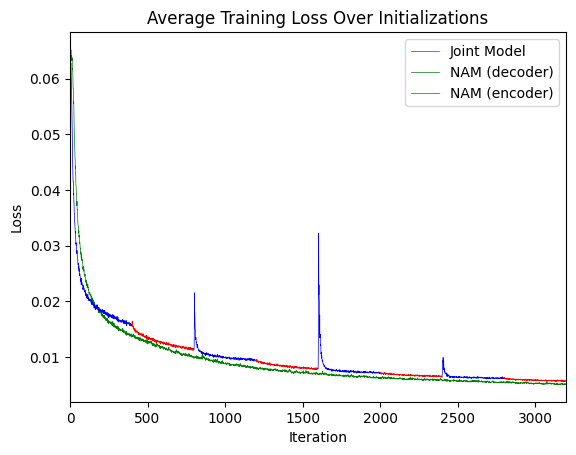



Average total weight updates per epoch:
    Joint Model: 18894645.0
    NAM Model (decoder): 9438345.0
    NAM Model (encoder): 9456300.0
    NAM Model (decoder and encoder): 9447322.5
    The Joint Model updates 2.00 times more weights per epoch compared to the NAM Model


Average run time per epoch:
    Joint Model: 32.67 seconds
    NAM Model (decoder): 26.25 seconds
    NAM Model (encoder): 28.98 seconds
    NAM Model (decoder and encoder): 27.61 seconds
    The NAM Model is 15.49% faster than the Joint Model


In [22]:
plot_joint_model = True
plot_NAM_model = True


# Calculate number of decoder and decoder epochs for later average calculations
if plot_NAM_model:
    num_decoder_epochs = sum([1 if param_count_NAM[epoch+1][1]=='d' else 0 for epoch in range(num_epochs)])
    num_encoder_epochs = sum([1 if param_count_NAM[epoch+1][1]=='e' else 0 for epoch in range(num_epochs)])
    if num_decoder_epochs > 0:
        inv_num_decoder_epochs = 1/num_decoder_epochs
    else:
        inv_num_decoder_epochs = np.nan
    if num_encoder_epochs > 0:
        inv_num_encoder_epochs = 1/num_encoder_epochs
    else:
        inv_num_encoder_epochs = np.nan


# Plotting the Loss
if plot_joint_model:
    for epoch in range(num_epochs):
        plt.plot(avg_loss_joint[epoch+1][0], avg_loss_joint[epoch+1][1], color='green', linewidth=0.5)


if plot_NAM_model:
    for epoch in range(num_epochs):
        if avg_loss_NAM[epoch+1][2] == 'd':  # plot decoder iteration segments
            plt.plot(avg_loss_NAM[epoch+1][0], avg_loss_NAM[epoch+1][1], color='blue', linewidth = 0.5)
        else:  # plot encoder iteration segments
            plt.plot(avg_loss_NAM[epoch+1][0], avg_loss_NAM[epoch+1][1], color='red', linewidth = 0.5)


plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Average Training Loss Over Initializations')
plt.xlim([0, num_epochs*num_iter])
plt.legend(['Joint Model', 'NAM (decoder)', 'NAM (encoder)'])
plt.show()


# Average total number of weight updates
print('\n')
print(f'Average total weight updates per epoch:')
if plot_joint_model:
    avg_joint_updates = (1/num_epochs)*sum(param_count_joint[epoch+1] for epoch in range(num_epochs))
    print(f'    Joint Model:', avg_joint_updates)

    avg_decoder_updates = inv_num_decoder_epochs*sum(param_count_NAM[epoch+1][0] if param_count_NAM[epoch+1][1]=='d' else 0 for epoch in range(num_epochs))
    avg_encoder_updates = inv_num_encoder_epochs*sum(param_count_NAM[epoch+1][0] if param_count_NAM[epoch+1][1]=='e' else 0 for epoch in range(num_epochs))
    print(f'    NAM Model (decoder):', avg_decoder_updates)
    print(f'    NAM Model (encoder):', avg_encoder_updates)
    avg_NAM_updates = np.nanmean([avg_decoder_updates, avg_encoder_updates])
    print(f'    NAM Model (decoder and encoder):', avg_NAM_updates)
if plot_joint_model and plot_NAM_model:
    print(f'    The Joint Model updates {avg_joint_updates/avg_NAM_updates:.2f} times more weights per epoch compared to the NAM Model')


# Average run time per epoch for each model
print('\n')
print(f'Average run time per epoch:')
if plot_joint_model:
    avg_joint_time = (1/num_epochs)*sum(avg_time_joint[epoch+1] for epoch in range(num_epochs))
    print(f'    Joint Model: {avg_joint_time:.2f} seconds')
if NAM_model:
    avg_decoder_time = inv_num_decoder_epochs*sum(avg_time_NAM[epoch+1][0] if avg_time_NAM[epoch+1][1]=='d' else 0 for epoch in range(num_epochs))
    avg_encoder_time = inv_num_encoder_epochs*sum(avg_time_NAM[epoch+1][0] if avg_time_NAM[epoch+1][1]=='e' else 0 for epoch in range(num_epochs))
    print(f'    NAM Model (decoder): {avg_decoder_time:.2f} seconds')
    print(f'    NAM Model (encoder): {avg_encoder_time:.2f} seconds')
    avg_NAM_time = np.nanmean([avg_decoder_time, avg_encoder_time])
    print(f'    NAM Model (decoder and encoder): {avg_NAM_time:.2f} seconds')
if plot_joint_model and plot_NAM_model:
    print(f'    The NAM Model is {(1-avg_NAM_time/avg_joint_time)*100:.2f}% faster than the Joint Model')